# Function Approximation

This is the notebook which creates Fig.8 of the paper.
It creates two datasets of random BAS data. The first (a) is used to train the model, while the second (b) is employed to evaluate/test the mode.
Similar to the other notbooks it is written s.a. one can easily switch between simulated annealing and quantum annealing. As the size of 144 nodes for a 12x12 BAS dataset becomes computational expensive to solve with simulated annealing, only quntum annealing was employed to create data.

In [3]:
from ising_learning_model import SimpleDataset, HiddenNodesInitialization, GammaInitialization, utils, QPUModel, AnnealingSettings, SimAnnealModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import json
import pickle
plt.style.use('science')



In [4]:
size = 12**2
num_samples = 80
cat_factor = 10 
solver = ["QPU", "SA"][0]

In [5]:
idx = "004"
name_short = f"bas_{size}_{num_samples}"
name = f"{name_short}_{solver}"

In [37]:
# create dataset
a = SimpleDataset()
a.create_data_bas(int(size ** (0.5)), num_samples, cat_factor )

b = SimpleDataset()
b.create_data_bas(int(size ** (0.5)), num_samples, cat_factor )

In [38]:
# load dataset
load = False 
if load:
    a = pickle.load(open(f"data/bas_{size}_{num_samples}_QPU_dataset_{idx}.pkl", "rb"))
    b = pickle.load(open(f"data/bas_{size}_{num_samples}_QPU_dataset_test_{idx}.pkl", "rb"))
    print("loaded")

In [45]:
if solver == "QPU":
    print("QPU")
    profile = "default"
    # profile = "prof"
    m = QPUModel(size, profile=profile, num_reads=1)
else:
    print("SA")
    settings_anneal = AnnealingSettings()
    settings_anneal.beta_range = [1,10]
    settings_anneal.num_reads = 100
    settings_anneal.num_sweeps = 1000
    settings_anneal.sweeps_per_beta = 1
    m = SimAnnealModel(size, settings_anneal)


# initialize Gamma matrix with zeros``
m.settings.gamma_init = GammaInitialization("zeros")

QPU
Searching QPU and computing embedding...
Embedding found.
using QPU: Advantage_system5.4


In [48]:
# set number of iterations
num_avg = 1
# set training settings
if solver == "QPU":
    m.settings.optim_steps = 15
    m.settings.learning_rate = 0.02
    m.settings.mini_batch_size = num_samples
    m.settings.learning_rate_lmd = 0
    m.lmd_init_value = -0.3

else:
    m.settings.optim_steps = 200
    m.settings.optim_steps = 30
    m.settings.learning_rate = 0.005
    # m.settings.learning_rate = 0.0005
    m.settings.mini_batch_size = num_samples
    m.settings.learning_rate_lmd = 0

    # setting initial values for epsilon and lambda
    m.lmd_init_value = 0.5
m.offset_init_value = 'sample'

In [56]:
# save sampler properties
with open("sampler_properties.json", "w") as f:
    json.dump(m._sampler.child.properties, f)

In [ ]:
# training
results = pd.DataFrame(columns=['run_idx', "epoch", "idx_minibatch", "loss"])
for i in range(num_avg):
    print("Iteration: ", i)
    verbose = False
    save_samples = True
    save_params = True
    if solver == "QPU":
        verbose = True
    r = m.train(a, save_params=save_params, save_samples=save_samples, verbose=verbose, test_set=b)
    # r = m.train(a, save_params=save_params, save_samples=save_samples, verbose=verbose, test_set=None)
    r.results['run_idx'] = i
    results = pd.concat([results, r.results], ignore_index=True)


In [105]:
total_results = pd.concat([r.results, r.results_test], keys=["train", "test"])
total_results = total_results.reset_index().rename(columns={"level_0": "set"})
total_results.to_csv(f"data/{name}_{idx}.csv")

total_samples = pd.concat([r.results_samples, r.results_samples_test], keys=["train", "test"])
total_samples = total_samples.reset_index().rename(columns={"level_0": "set"})
total_samples.to_csv(f"data/{name}_samples_{idx}.csv")

In [106]:
# save results
pickle.dump(a, open(f"data/{name}_dataset_{idx}.pkl", "wb"))
pickle.dump(b, open(f"data/{name}_dataset_test_{idx}.pkl", "wb"))
m._save_model(f"data/{name}_model_{idx}.pkl")

# Plotting

This section just loads the previously computed data and creates Fig. 8.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import pickle
import matplotlib
plt.style.use('science')

In [13]:
num_samples = 80
idx = "004"

name_short = f"bas_{size}_{num_samples}_{solver}"

results = pd.read_csv(f"data/{name_short}_{idx}.csv", index_col=0)
samples = pd.read_csv(f"data/{name_short}_samples_{idx}.csv", index_col=0)

results['name'] = ["SA"] * len(results)

In [14]:
# threshold = cat_factor / 2
epochs = samples["epoch"].max() 
# threshold = samples.query(f"set == 'train' and epoch == {epochs}")["energy"].mean()
threshold = 5

In [15]:
# compute accuracy
samples["correct"] = np.sign(samples["energy"] - threshold) == np.sign(samples["target"] - threshold)
samples["epoch"] = samples["epoch"] + 1
results["epoch"] = results["epoch"] + 1
samples
summed_samples = samples[samples["correct"] == 1].groupby(["epoch", "set"])["correct"].sum().reset_index()
summed_samples["correct_rel"] = summed_samples["correct"] / num_samples


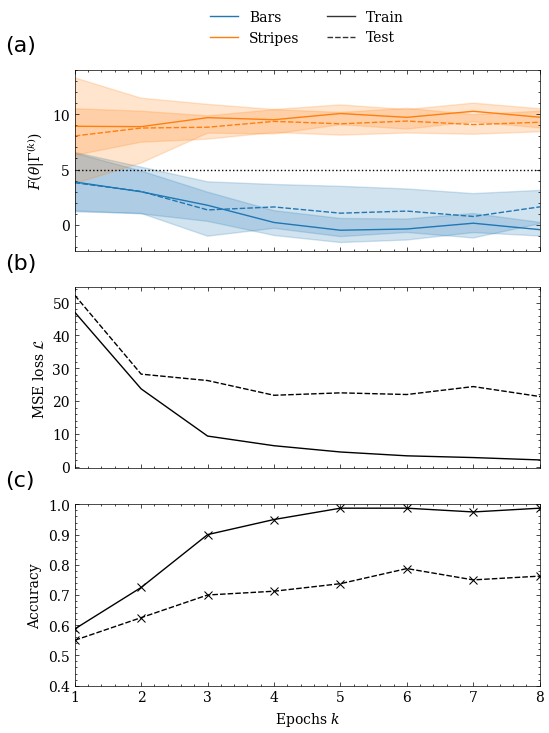

In [16]:
plt.rc('text', usetex=False)

fig, (ax, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(6, 8))
samples_plot = samples.query("idx_theta < 20")
# plot energy
sns.lineplot(data=samples_plot, x="epoch", y="energy", hue="target", palette="tab10", 
             ax=ax, legend=True, style="set", err_style="band")
ax.hlines(threshold, 0, 50, color="black", linestyle=":", label="threshold")
ax.set_ylabel(r"$F(\theta \vert \Gamma^{(k)})$")
ax.set_xlim(1, 10)
ax.text(-0.15,1.1, "(a)", transform=ax.transAxes, size=16, fontfamily="sans-serif")
handles, labels = ax.get_legend_handles_labels()
labels[1] = "Bars"
labels[2] = "Stripes"
labels[3] = ""
labels[4] = "Train"
labels[5] = "Test"
ax.legend(handles=handles[1:-1], labels=labels[1:-1], loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2)

# plot loss
sns.lineplot(data=results, x="epoch", y="loss",  ax=ax2, legend=False, style="set", color="black")
ax2.set_ylabel(r"MSE loss $\mathcal{L}$")
ax2.text(-0.15,-0.1, "(b)", transform=ax.transAxes, size=16, fontfamily="sans-serif")

# plot classification
sns.lineplot(data=summed_samples, x="epoch", y="correct_rel",  ax=ax3, style="set", color="black",
    style_order=["train", "test"], legend=False, markers=["x", "x"], markeredgecolor=None)
ax3.set_ylim(0.4, 1)
ax3.set_xlim(1, 8)

ax3.set_xlabel(r"Epochs $k$")
ax3.set_ylabel(r"Accuracy")
ax3.text(-0.15,-1.3, "(c)", transform=ax.transAxes, size=16, fontfamily="sans-serif")

fig.savefig(f"figures/bas_results.pdf", bbox_inches="tight")